<a href="https://colab.research.google.com/github/ovotom/toms_datascience_learning/blob/master/potato_not_potato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Potato not-potato

The slides for my talk are available [here](https://slides.com/hamishdickson/transfer-learning/#/)

You will have to supply your own potato photos

In [0]:
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms, models

from PIL import Image
from torch.autograd import Variable
from potato_not_potato import class_names

# you'd only really do this for a demo
seed=42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [0]:
model = models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

954 banana


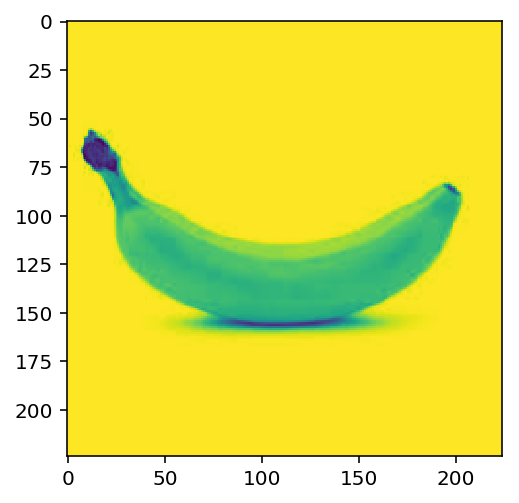

285 Egyptian cat


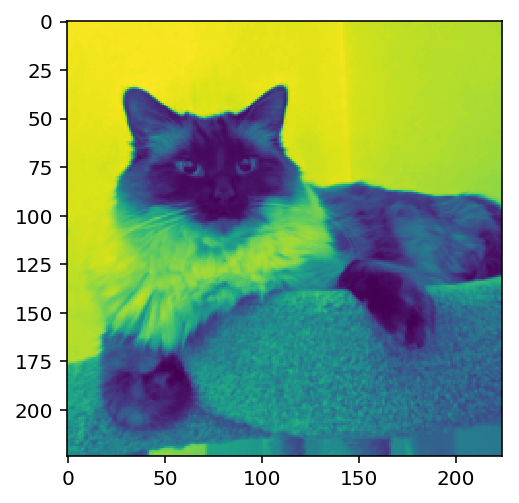

1 goldfish, Carassius auratus


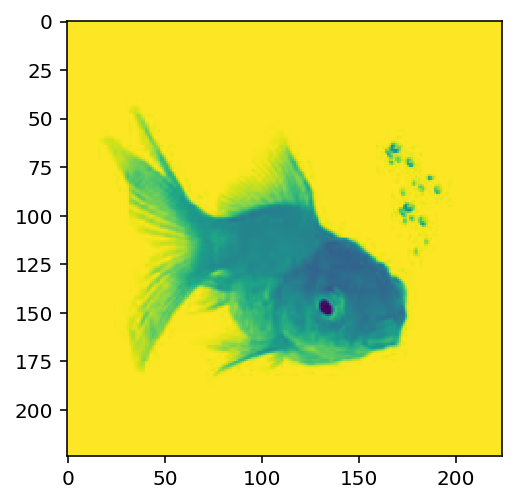

951 lemon


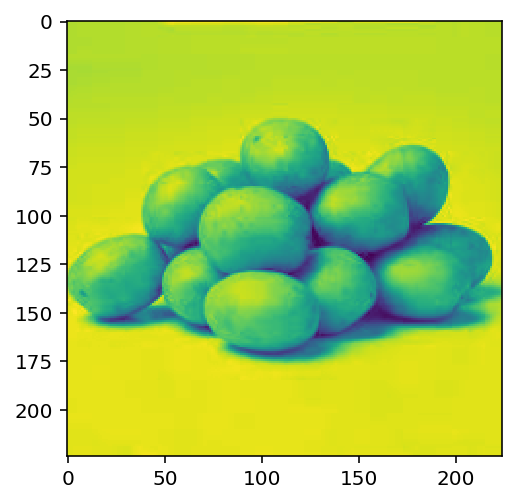

930 French loaf


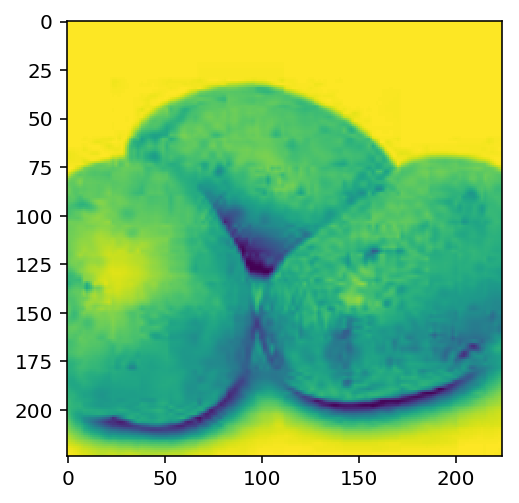

In [0]:
test_potato_loader = transforms.Compose([
                                           transforms.Resize(224),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                          ])

test_data = datasets.ImageFolder('./potato_not_potato/test', transform=test_potato_loader)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)

def image_loader(model, class_name):
    for images, labels in test_loader:
        ps = model(images)    
        top_p, top_class = ps.topk(1, dim=1)
        
        for c, image in zip(top_class.numpy(), images):
            print(c[0], class_name(c[0]))
            plt.imshow(image.numpy()[1,:])
            plt.show()


image_loader(model, class_names.get_class_name)

In [0]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512, 2)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_data = datasets.ImageFolder('./potato_not_potato/train', transform=train_transforms)
validation_data = datasets.ImageFolder('./potato_not_potato/validation', transform=test_potato_loader)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=64)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [0]:
training_losses = []
validation_losses = []
validation_accs = []

In [0]:
%%time

EPOCHS = 6
    
for e in range(EPOCHS):    
    print(f"epoch {e + 1} of {EPOCHS}")
    
    running_loss = 0
    accuracy = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print(f"training loss: {running_loss}")
    training_losses.append(running_loss)
    
    # ------------------------------
    # with the training part done we can now evaluate our model
        
    with torch.no_grad(): # makes evaluation quicker/less memory hungry
        model.eval() # turn things like dropout off
        
        validation_running_loss = 0
        results = np.array([])
        
        for images, labels in validation_loader:
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            
            validation_running_loss += loss.item()
            
            ps = torch.exp(log_ps)
            _, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
        validation_losses.append(validation_running_loss)
        
        model.train() # turn dropout etc back on
        
    # -------------------------------
    # todo automatically kill training if we're starting to overfit
    
    print(f"validation loss {validation_running_loss}")
    print(f"validation accuracy {accuracy}")
    validation_accs.append(accuracy)

epoch 1 of 6
training loss: 7.606460392475128
validation loss 0.4617873728275299
validation accuracy 0.7749999761581421
epoch 2 of 6
training loss: 5.412262856960297
validation loss 0.2397756576538086
validation accuracy 0.9750000238418579
epoch 3 of 6
training loss: 4.075684234499931
validation loss 0.24011392891407013
validation accuracy 0.949999988079071
epoch 4 of 6
training loss: 3.3695565909147263
validation loss 0.15618813037872314
validation accuracy 0.9750000238418579
epoch 5 of 6
training loss: 2.807764284312725
validation loss 0.16343657672405243
validation accuracy 0.9750000238418579
epoch 6 of 6
training loss: 2.866398513317108
validation loss 0.12327580153942108
validation accuracy 0.9750000238418579
CPU times: user 1min 45s, sys: 14.2 s, total: 1min 59s
Wall time: 1min 59s


In [0]:
len(validation_losses)

6

Text(0.5, 0, 'epoch')

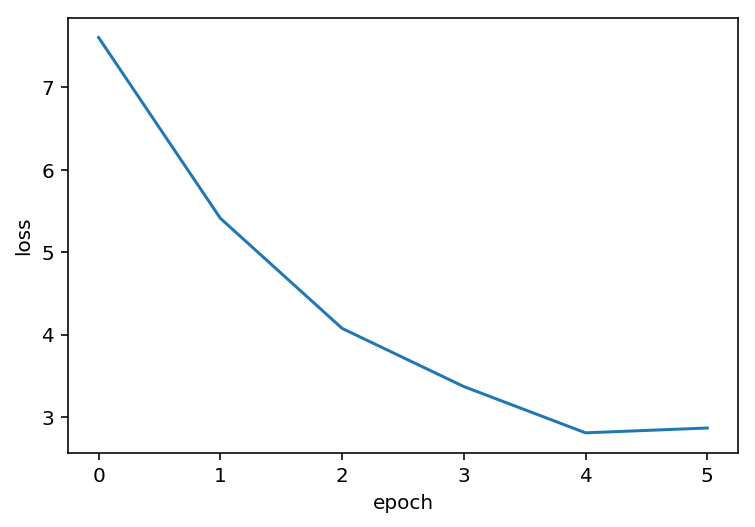

In [0]:
plt.plot(training_losses)
plt.ylabel('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

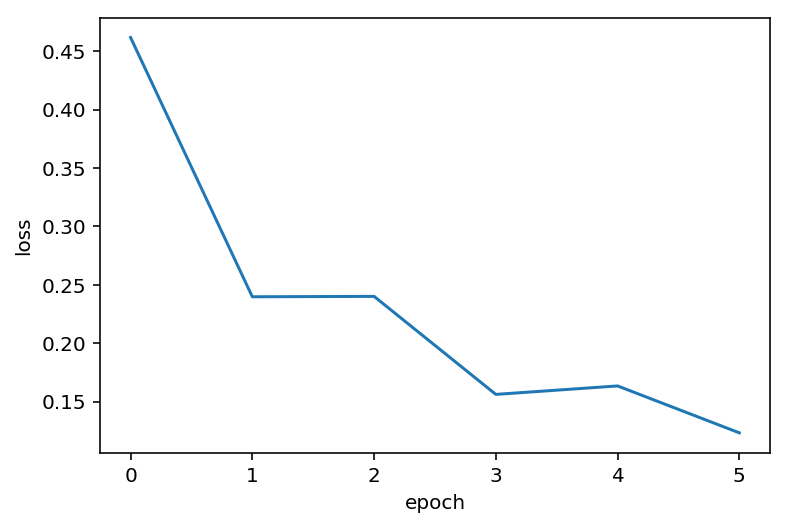

In [0]:
plt.plot(validation_losses)
plt.ylabel('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

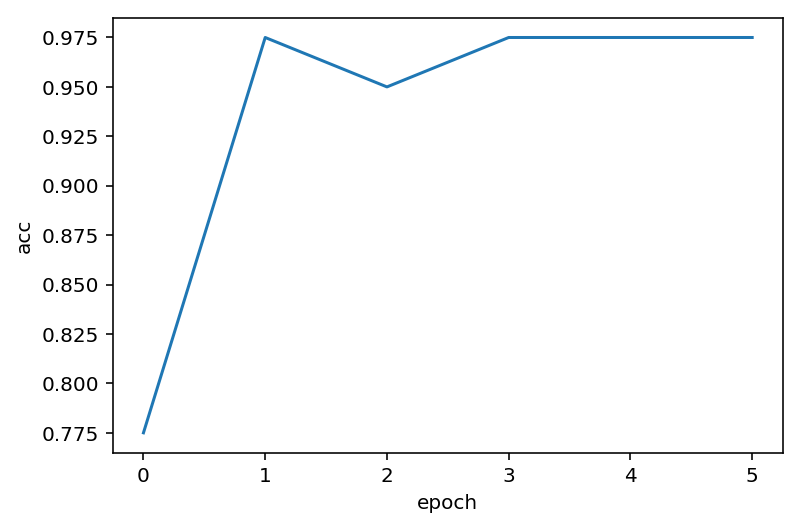

In [0]:
plt.plot(validation_accs)
plt.ylabel('acc')
plt.xlabel('epoch')

0 not potato ❌


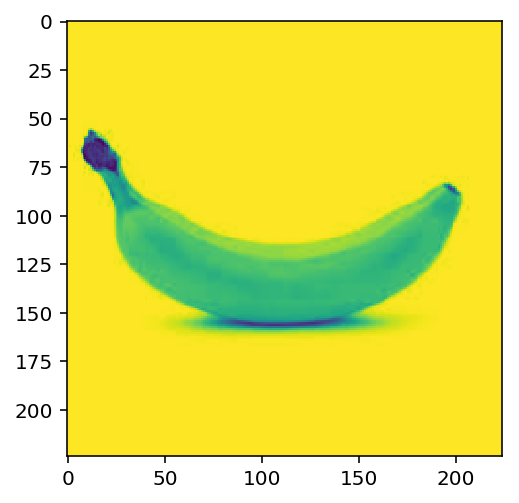

0 not potato ❌


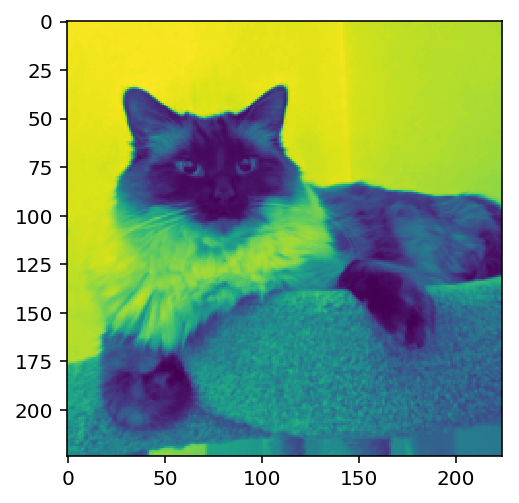

0 not potato ❌


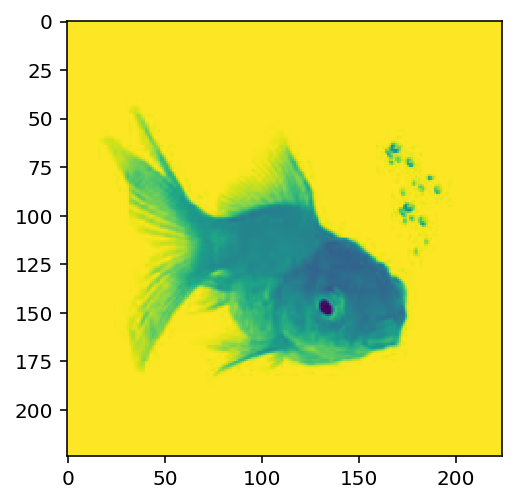

1 potato 🥔


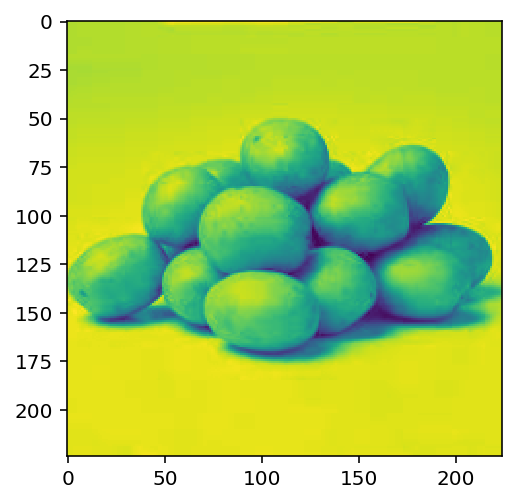

1 potato 🥔


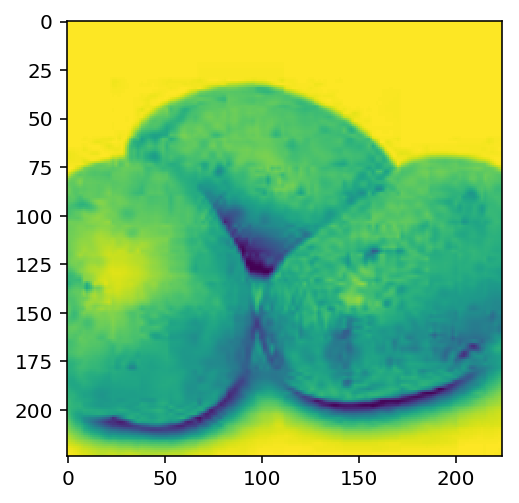

In [0]:
def potato_not_potato(c):
    if c == 1:
        return "potato 🥔"
    else:
        return "not potato ❌"

image_loader(model, potato_not_potato)

exercise for the reader: any kind of testing at all would be nice :)